In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer


In [211]:
#Importing the cleaned dataset
df = pd.read_csv('../data/loans_cleaned.csv')
df.head()

,loan_id,loan_amnt,term_months,int_rate,grade,sub_grade,emp_length_years_txt,home_ownership,annual_inc,dti,revol_util,earliest_cr_line,open_acc,default_status
0,68407277,3600.0,36,0.140,C,C4,10,MORTGAGE,55000.0,0.059,0.297,22,7,0
1,68355089,24700.0,36,0.120,C,C1,10,MORTGAGE,65000.0,0.161,0.192,25,22,0
2,68341763,20000.0,60,0.108,B,B4,10,MORTGAGE,63000.0,0.108,0.562,25,6,0
3,66310712,35000.0,60,0.149,C,C5,10,MORTGAGE,110000.0,0.171,0.116,16,13,0
4,68476807,10400.0,60,0.225,F,F1,3,MORTGAGE,104433.0,0.254,0.645,27,12,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260639 entries, 0 to 2260638
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   loan_id               int64  
 1   loan_amnt             float64
 2   term_months           int64  
 3   int_rate              float64
 4   grade                 object 
 5   sub_grade             object 
 6   emp_length_years_txt  object 
 7   home_ownership        object 
 8   annual_inc            float64
 9   dti                   float64
 10  revol_util            float64
 11  earliest_cr_line      int64  
 12  open_acc              int64  
 13  default_status        int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 241.5+ MB


In [212]:
df = df.drop(columns=['loan_id'])


# Exploration

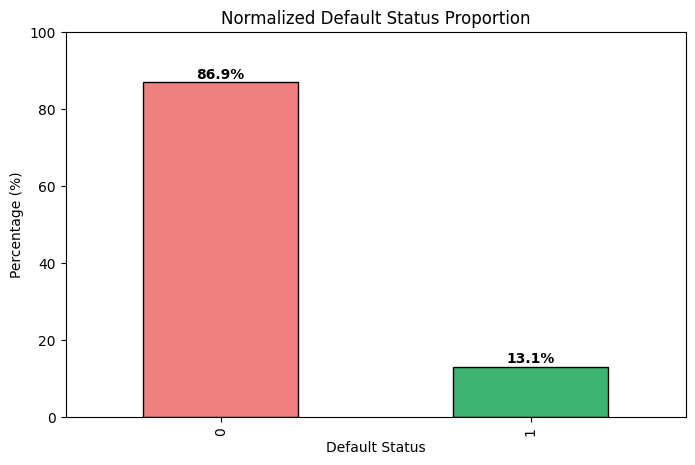

In [13]:
#First we want to see the normalized proportion of defaults
total = len(df)
proportions = df['default_status'].value_counts(normalize=True) * 100
plt.figure(figsize=(8,5))
proportions.plot(kind='bar', color=['lightcoral','mediumseagreen'], edgecolor='black')
plt.title('Normalized Default Status Proportion')
plt.xlabel('Default Status')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
for i, v in enumerate(proportions):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
plt.show()

We observe an obvious class imbalance.

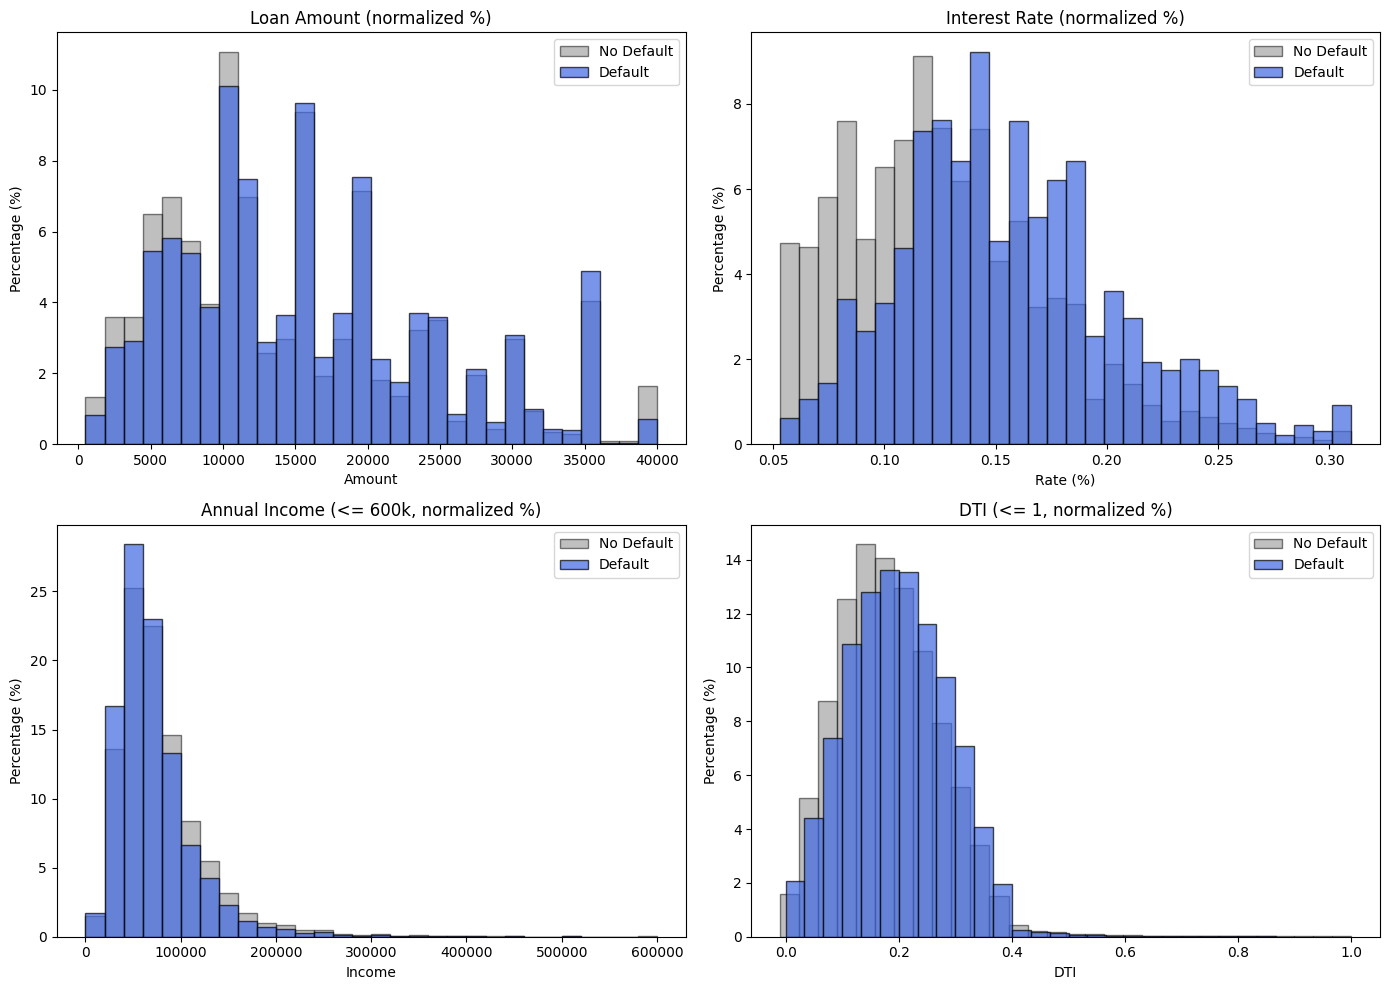

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

df_default = df[df['default_status'] == 1]
df_non_default = df[df['default_status'] == 0]

def plot_normalized_hist(ax, series_default, series_non_default, bins, title, xlabel):
    # Pesos normalizados para que cada grupo sume 100%
    w_def = np.ones(len(series_default)) / len(series_default) * 100
    w_non = np.ones(len(series_non_default)) / len(series_non_default) * 100
    
    ax.hist(series_non_default, bins=bins, color='grey', alpha=0.5, 
            edgecolor='black', weights=w_non, label='No Default')
    ax.hist(series_default, bins=bins, color='royalblue', alpha=0.7, 
            edgecolor='black', weights=w_def, label='Default')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Percentage (%)')
    ax.legend()

# Loan Amount
plot_normalized_hist(axes[0], df_default['loan_amnt'], df_non_default['loan_amnt'],
                     bins=30, title='Loan Amount (normalized %)', xlabel='Amount')

# Interest Rate
plot_normalized_hist(axes[1], df_default['int_rate'], df_non_default['int_rate'],
                     bins=30, title='Interest Rate (normalized %)', xlabel='Rate (%)')

# Annual Income (<= 600k)
plot_normalized_hist(axes[2], 
                     df_default[df_default['annual_inc'] <= 600000]['annual_inc'],
                     df_non_default[df_non_default['annual_inc'] <= 600000]['annual_inc'],
                     bins=30, title='Annual Income (<= 600k, normalized %)', xlabel='Income')

# DTI (<= 1)
plot_normalized_hist(axes[3], 
                     df_default[df_default['dti'] <= 1]['dti'],
                     df_non_default[df_non_default['dti'] <= 1]['dti'],
                     bins=30, title='DTI (<= 1, normalized %)', xlabel='DTI')

plt.tight_layout()
plt.show()


In [9]:
# Count negative values in the four main categories
categories = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']
for col in categories:
    count_neg = (df[col] < 0).sum()
    print(f"{col}: {count_neg} negative values")

loan_amnt: 0 negative values
int_rate: 0 negative values
annual_inc: 0 negative values
dti: 2 negative values


In [213]:
#Delating the negative values, , which are not economically meaningful
df = df[df['dti'] >= 0]

<Axes: ylabel='annual_inc'>

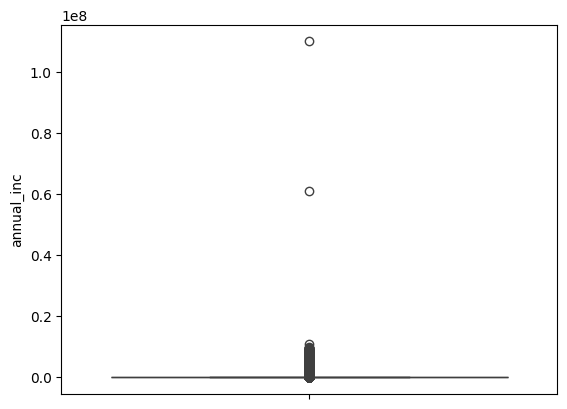

In [12]:
#Let´s analyse the outliers

sns.boxplot(data=df['annual_inc'])

In [75]:
df['annual_inc'].quantile([0.5, 0.75, 0.90, 0.95, 0.99, 0.999])


0.500     65000.0
0.750     93000.0
0.900    130000.0
0.950    160000.0
0.990    270000.0
0.999    600000.0
Name: annual_inc, dtype: float64

In [214]:
#Delating all the values above the 99.9 percentile identified as outliers. Since they likely represent data entry errors or unrealistic cases, 
#they were excluded from the dataset.
df = df[df['annual_inc'] <= df['annual_inc'].quantile(0.999)] 

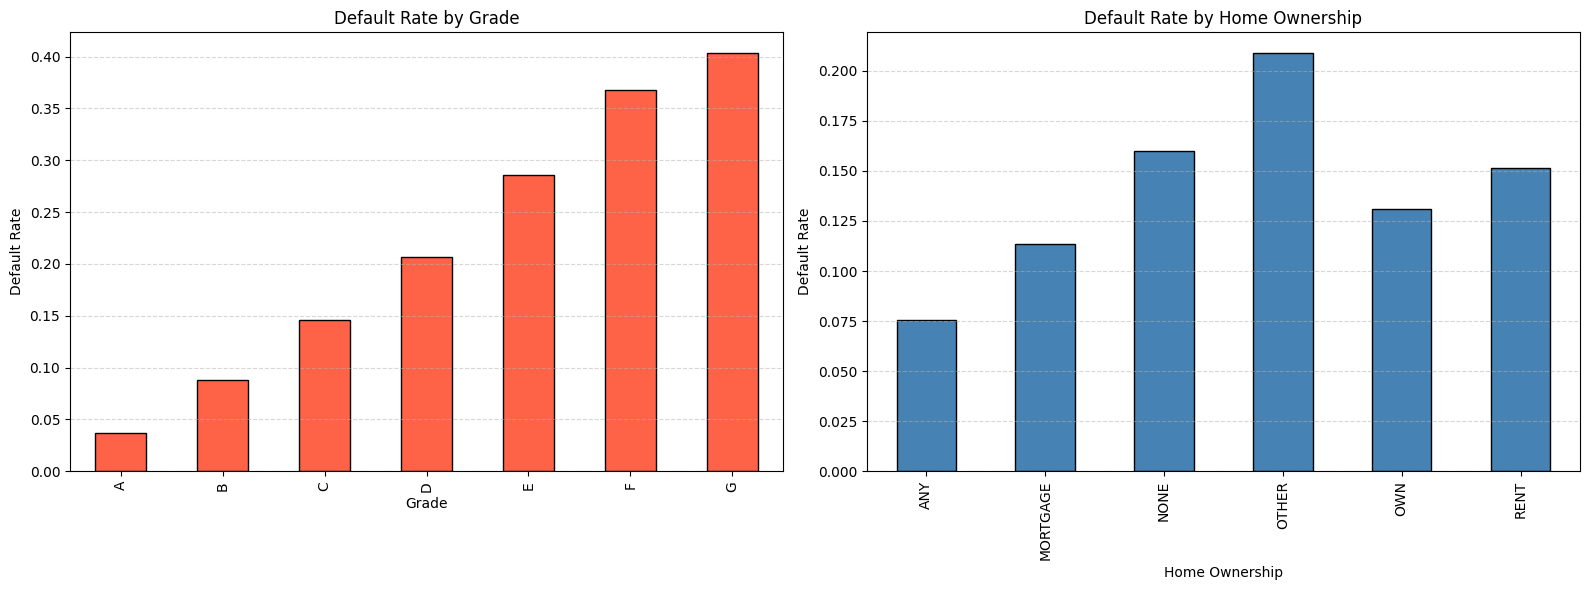

In [14]:
# Default rate distribution by grade and home ownership
import matplotlib.pyplot as plt

# Assuming the default column is named 'default_status', grade column is 'grade', and home ownership column is 'home_ownership'
# If your column names are different, replace them below
default_by_grade = df.groupby('grade')['default_status'].mean()
default_by_home = df.groupby('home_ownership')['default_status'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Default rate by grade
default_by_grade.plot(kind='bar', color='tomato', edgecolor='black', ax=axes[0])
axes[0].set_title('Default Rate by Grade')
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Default Rate')
axes[0].set_xticks(range(len(default_by_grade.index)))
axes[0].set_xticklabels(default_by_grade.index)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Default rate by home ownership
default_by_home.plot(kind='bar', color='steelblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Default Rate by Home Ownership')
axes[1].set_xlabel('Home Ownership')
axes[1].set_ylabel('Default Rate')
axes[1].set_xticks(range(len(default_by_home.index)))
axes[1].set_xticklabels(default_by_home.index)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

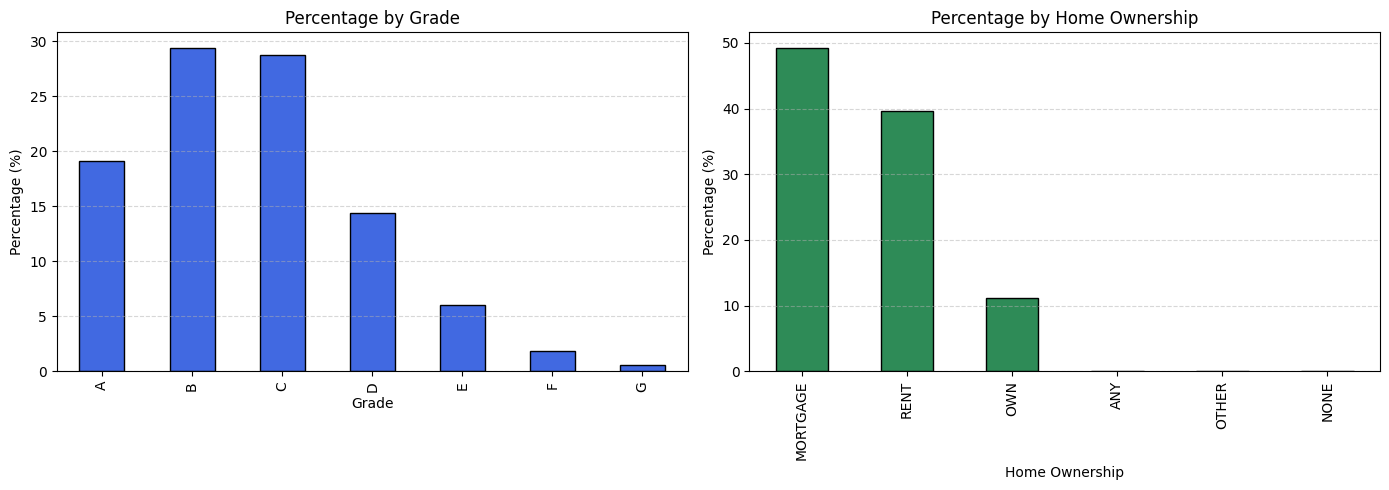

In [24]:
# Distribution of grade and home ownership counts
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Grade distribution
df['grade'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='royalblue', edgecolor='black')
axes[0].set_title('Count by Grade')
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Home ownership distribution
df['home_ownership'].value_counts().plot(kind='bar', ax=axes[1], color='seagreen', edgecolor='black')
axes[1].set_title('Count by Home Ownership')
axes[1].set_xlabel('Home Ownership')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<Axes: >

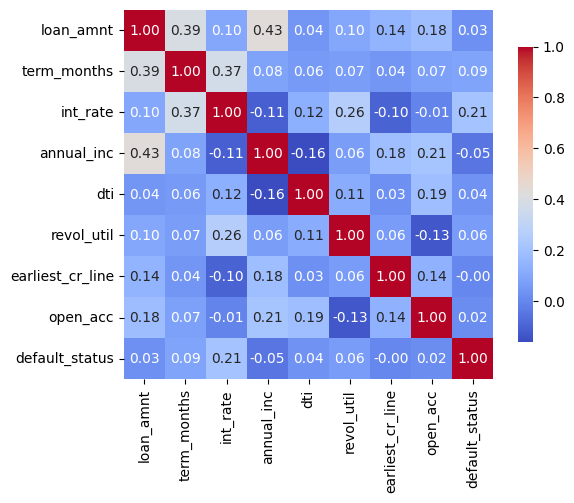

In [59]:
#Let´s see the correlation matrix with the numerical data

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[num_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

## Conclusions – Exploration

- The exploratory analysis revealed a strong class imbalance, with significantly fewer default cases compared to non-defaults.

- Data cleaning included the removal of outliers and the correction of variables with no economic meaning, such as negative DTI values.

- Distributions of financial variables showed clear patterns:

    - Higher interest rates are strongly associated with default, suggesting that interest rate bins could be a useful feature to capture risk thresholds.

    - Borrowers with lower annual income or smaller loan amounts display a higher tendency to default, which motivates the creation of binary indicators for critical ranges (e.g., small loans, low income).

    - Higher DTI ratios (even within the limited range analyzed) are linked to an increased probability of default, pointing to the potential benefit of binning or capping DTI values to model risk more effectively.

- When analyzing categorical variables:

    - Loan grade showed a consistent trend, with lower grades being strongly associated with higher default probability, which indicates that ordinal encoding or grouping of grades could improve model interpretability.

    - Loan purpose/type displayed heterogeneous patterns, with certain categories (e.g., small personal loans) presenting higher risk, suggesting that dummy variables for loan purpose could enhance predictive power.

- The correlation matrix highlighted meaningful associations among financial variables, confirming that features such as interest rate and grade are strongly related to default behavior. This opens the possibility of building interaction terms (e.g., income-to-loan ratio, loan amount vs. interest rate).

# Feature engeniergin

In [60]:
X = df.drop(columns=['default_status'])
y = df['default_status'].astype(int)

cat_cols = X.select_dtypes(include=['object']).columns
# Apply OneHotEncoding to the categorical features
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)



# 2. Train/test split (ajustá con tus fechas si tenés variable temporal)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Entrenar Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=200,      # cantidad de árboles
    max_depth=None,        # sin límite de profundidad
    min_samples_leaf=50,   # evita sobreajuste, ajustá según tamaño dataset
    n_jobs=-1,             # usa todos los núcleos
    random_state=42
)
rf.fit(X_train, y_train)

# 4. Predicciones de probabilidad
p = rf.predict_proba(X_test)[:,1]

# 5. Métricas
print("ROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC:", average_precision_score(y_test, p))

ROC-AUC: 0.725657450954953
PR-AUC: 0.2813840214437287


In [215]:
#Because we see a big relation between the grade and the default status, we will create a new feature
#If the grade is high than D
df['high_grade'] = df['grade'].apply(lambda x: 1 if x > 'D' else 0)
#Now we generate the following ratios


den = df['annual_inc'].replace(0, 1)  # evita división por cero
df['loan_to_income'] = df['loan_amnt'] / den

df['critical_int_rate'] = ((df['int_rate'] > 0.13)).astype(int)

# Media de int_rate por grade
avg_rate_per_grade = df.groupby("grade")["int_rate"].transform("mean")

# Nueva feature: diferencia respecto al promedio de su grade
df["int_rate_diff_from_grade"] = df["int_rate"] - avg_rate_per_grade
df["int_rate_ratio_grade"] = df["int_rate"] / avg_rate_per_grade

#Let's generate a bin for interest rate

kbd = KBinsDiscretizer(
    n_bins=20,               # número de bins que querés
    encode='ordinal',       # cómo representar los bins
    strategy='kmeans'     # "uniform", "quantile" o "kmeans"
)

interest_rate_binned = kbd.fit_transform(df[['int_rate']])
df['int_rate_bin'] = interest_rate_binned.astype(int)

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2258472 entries, 0 to 2260638
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   loan_amnt                 float64
 1   term_months               int64  
 2   int_rate                  float64
 3   grade                     object 
 4   sub_grade                 object 
 5   emp_length_years_txt      object 
 6   home_ownership            object 
 7   annual_inc                float64
 8   dti                       float64
 9   revol_util                float64
 10  earliest_cr_line          int64  
 11  open_acc                  int64  
 12  default_status            int64  
 13  high_grade                int64  
 14  loan_to_income            float64
 15  critical_int_rate         int64  
 16  int_rate_diff_from_grade  float64
 17  int_rate_ratio_grade      float64
 18  int_rate_bin              int64  
dtypes: float64(8), int64(7), object(4)
memory usage: 344.6+ MB


In [218]:
X = df.drop(columns=['default_status'])
y = df['default_status'].astype(int)

# Apply OneHotEncoding to the categorical features

cat_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


# 2. Train/test split (ajustá con tus fechas si tenés variable temporal)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Entrenar Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=200,      # cantidad de árboles
    max_depth=None,        # sin límite de profundidad
    min_samples_leaf=50,   # evita sobreajuste, ajustá según tamaño dataset
    n_jobs=-1,             # usa todos los núcleos
    random_state=42
)
rf.fit(X_train, y_train)

# 4. Predicciones de probabilidad
p = rf.predict_proba(X_test)[:,1]

# 5. Métricas
print("ROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC:", average_precision_score(y_test, p))

ROC-AUC: 0.7386409314492798
PR-AUC: 0.2882341264676354


# TEST IGNORAR

In [94]:
cantidad_valores = 100000

df_small, _ = train_test_split(df, train_size=cantidad_valores, random_state=42)

In [95]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 285829 to 2221231
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             100000 non-null  float64
 1   term_months           100000 non-null  int64  
 2   int_rate              100000 non-null  float64
 3   grade                 100000 non-null  object 
 4   sub_grade             100000 non-null  object 
 5   emp_length_years_txt  100000 non-null  object 
 6   home_ownership        100000 non-null  object 
 7   annual_inc            100000 non-null  float64
 8   dti                   100000 non-null  float64
 9   revol_util            100000 non-null  float64
 10  earliest_cr_line      100000 non-null  int64  
 11  open_acc              100000 non-null  int64  
 12  default_status        100000 non-null  int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 10.7+ MB


In [96]:
#BASE LINAE MODEL WITH THE SMALL DATASET

X = df_small.drop(columns=['default_status'])
y = df_small['default_status'].astype(int)

# Apply OneHotEncoding to the categorical features

cat_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


# 2. Train/test split (ajustá con tus fechas si tenés variable temporal)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Entrenar Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=200,      # cantidad de árboles
    max_depth=None,        # sin límite de profundidad
    min_samples_leaf=50,   # evita sobreajuste, ajustá según tamaño dataset
    n_jobs=-1,             # usa todos los núcleos
    random_state=42
)
rf.fit(X_train, y_train)

# 4. Predicciones de probabilidad
p = rf.predict_proba(X_test)[:,1]

# 5. Métricas
print("ROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC:", average_precision_score(y_test, p))

ROC-AUC: 0.7119940510298242
PR-AUC: 0.2734358473780341


In [177]:
df_small_alterado = df_small.copy()

In [178]:
#Because we see a big relation between the grade and the default status, we will create a new feature
#If the grade is high than D
df_small_alterado['high_grade'] = df_small_alterado['grade'].apply(lambda x: 1 if x > 'D' else 0)
#Now we generate the following ratios



In [179]:

den = df_small_alterado['annual_inc'].replace(0, 1)  # evita división por cero
df_small_alterado['loan_to_income'] = df_small_alterado['loan_amnt'] / den

In [ ]:
# #Because we see that the DTI is an important feature, we will create a new feature

# kbd = KBinsDiscretizer(
#     n_bins=20,               # número de bins que querés
#     encode='ordinal',       # cómo representar los bins
#     strategy='kmeans'     # "uniform", "quantile" o "kmeans"
# )

# dti_binned = kbd.fit_transform(df_small_alterado[['dti']])
# df_small_alterado['dti_bin'] = dti_binned.astype(int)  



In [ ]:
# df_small_alterado['log_annual_inc'] = np.log1p(df_small_alterado['annual_inc'])

In [219]:
df_small_alterado['loan_term_ratio'] = df_small_alterado['loan_amnt'] / df_small_alterado['term_months']

In [ ]:
# df_small_alterado['log_loan_amount'] = np.log1p(df_small_alterado['loan_amnt'])

In [180]:
df_small_alterado['critical_int_rate'] = ((df_small_alterado['int_rate'] > 0.13)).astype(int)

In [ ]:
df_small_alterado['critical_loan_amnt'] = (df_small_alterado['loan_amnt'] < 12000).astype(int)

In [ ]:
# #Let's generate a bin for interest rate

# kbd = KBinsDiscretizer(
#     n_bins=10,               # número de bins que querés
#     encode='ordinal',       # cómo representar los bins
#     strategy='kmeans'     # "uniform", "quantile" o "kmeans"
# )

# loan_amnt_binned = kbd.fit_transform(df_small_alterado[['loan_amnt']])
# df_small_alterado['loan_amnt_bin'] = loan_amnt_binned.astype(int)

In [ ]:
# kbd = KBinsDiscretizer(
#     n_bins=20,               # número de bins que querés
#     encode='ordinal',       # cómo representar los bins
#     strategy='kmeans'     # "uniform", "quantile" o "kmeans"
# )

# interest_rate_binned = kbd.fit_transform(df_small_alterado[['annual_inc']])
# df_small_alterado['annual_inc_bin'] = interest_rate_binned.astype(int)

In [181]:
# Media de int_rate por grade
avg_rate_per_grade = df_small_alterado.groupby("grade")["int_rate"].transform("mean")

# Nueva feature: diferencia respecto al promedio de su grade
df_small_alterado["int_rate_diff_from_grade"] = df_small_alterado["int_rate"] - avg_rate_per_grade
df_small_alterado["int_rate_ratio_grade"] = df_small_alterado["int_rate"] / avg_rate_per_grade


In [209]:
#Let's generate a bin for interest rate

kbd = KBinsDiscretizer(
    n_bins=20,               # número de bins que querés
    encode='ordinal',       # cómo representar los bins
    strategy='kmeans'     # "uniform", "quantile" o "kmeans"
)

interest_rate_binned = kbd.fit_transform(df_small_alterado[['int_rate']])
df_small_alterado['int_rate_bin'] = interest_rate_binned.astype(int)

In [217]:
df_small_alterado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 285829 to 2221231
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   loan_amnt                 100000 non-null  float64
 1   term_months               100000 non-null  int64  
 2   int_rate                  100000 non-null  float64
 3   grade                     100000 non-null  object 
 4   sub_grade                 100000 non-null  object 
 5   emp_length_years_txt      100000 non-null  object 
 6   home_ownership            100000 non-null  object 
 7   annual_inc                100000 non-null  float64
 8   dti                       100000 non-null  float64
 9   revol_util                100000 non-null  float64
 10  earliest_cr_line          100000 non-null  int64  
 11  open_acc                  100000 non-null  int64  
 12  default_status            100000 non-null  int64  
 13  high_grade                100000 non-null  

In [220]:
#BASE LINAE MODEL WITH THE SMALL DATASET

X = df_small_alterado.drop(columns=['default_status'])
y = df_small_alterado['default_status'].astype(int)

# Apply OneHotEncoding to the categorical features

cat_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


# 2. Train/test split (ajustá con tus fechas si tenés variable temporal)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Entrenar Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=200,      # cantidad de árboles
    max_depth=None,        # sin límite de profundidad
    min_samples_leaf=50,   # evita sobreajuste, ajustá según tamaño dataset
    n_jobs=-1,             # usa todos los núcleos
    random_state=42
)
rf.fit(X_train, y_train)

# 4. Predicciones de probabilidad
p = rf.predict_proba(X_test)[:,1]

# 5. Métricas
print("ROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC:", average_precision_score(y_test, p))

ROC-AUC: 0.7241043732439507
PR-AUC: 0.2840015346345618


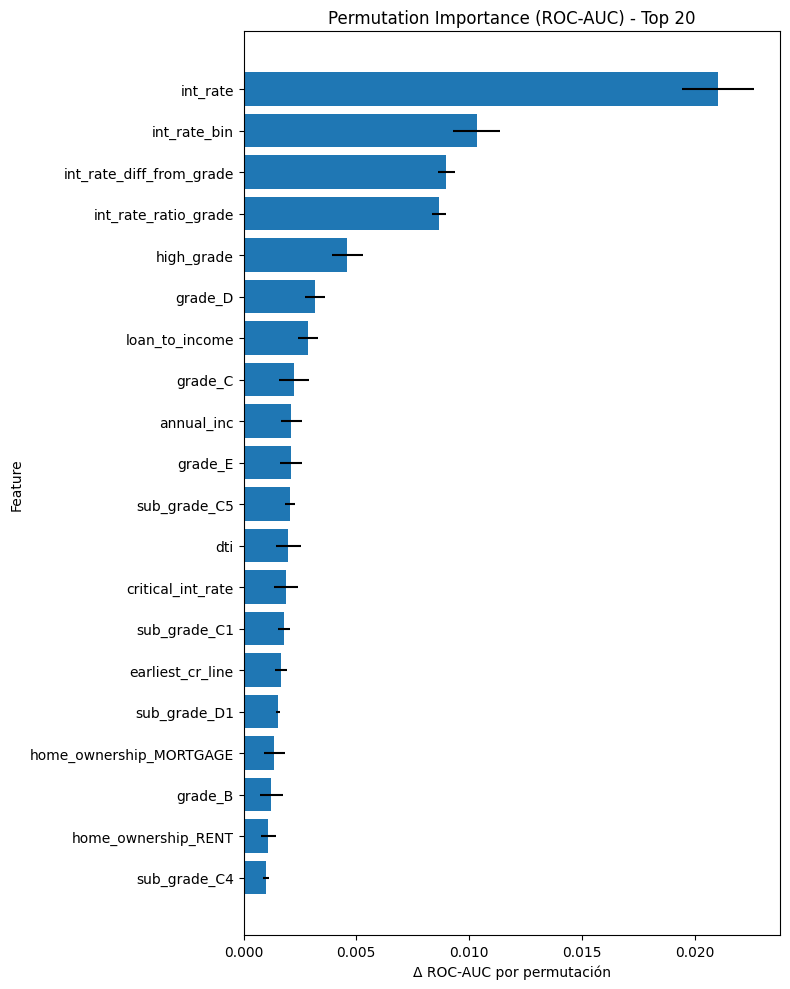

In [184]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Permutation Importance con ROC-AUC ---
result_roc = permutation_importance(
    rf,                      # modelo ya entrenado
    X_test, y_test,          # solo sobre test para evitar leakage
    scoring="roc_auc",       # métrica coherente con tu evaluación
    n_repeats=10,            # más repeticiones -> estimación más estable
    random_state=42,
    n_jobs=-1
)

imp_roc = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": result_roc.importances_mean,
    "importance_std": result_roc.importances_std
}).sort_values("importance_mean", ascending=False)

top_n = 20  # cambialo si querés ver más/menos
plot_roc = imp_roc.head(top_n).iloc[::-1]  # invertimos para barh ascendente

plt.figure(figsize=(8, 10))
plt.barh(plot_roc["feature"], plot_roc["importance_mean"], xerr=plot_roc["importance_std"])
plt.title(f"Permutation Importance (ROC-AUC) - Top {top_n}")
plt.xlabel("Δ ROC-AUC por permutación")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
